# 単純な量子回路をゼロから書く

{doc}`第一回の前半 <chsh_inequality>`で、量子回路の基本的な書き方と実機での実行の仕方を学びました。そこで出てきたように、QCでは量子レジスタに特定の量子状態を実現することが計算を行うこととなります。

後半では、基本的なゲートを組み合わせて様々な量子状態を作る実習を行います。

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$

## シミュレータで量子状態を調べる

前半で見たように、QCで実現される量子状態は、量子力学の公理に基づいて理論的に計算・予測できます。そこで用いられる数学的操作も単なる足し算や掛け算（線形演算）なので、実はQCの量子状態は（古典）計算機で比較的簡単に計算できます。当然のことですが、QCは何も魔法のブラックボックスというわけではありません。

ただし、古典計算機で量子状態を再現するためには、特殊な場合を除いて、量子ビット数の指数関数的な量のメモリが必要になります。これも前半で見たように、$n$量子ビットあれば、系の自由度（degrees of freedom / d.o.f.: 実数自由パラメータの数）は$2^{n+1} - 2$ですので、例えば各自由度を64ビットの浮動小数点で表現するとしたら、必要なメモリは(-2を無視して)

$$
2^6\, \mathrm{(bits / d.o.f.)} \times 2^{n+1}\, \mathrm{(d.o.f.)} \times 2^{-3}\, \mathrm{(bytes / bit)} = 2^{n+4}\, \mathrm{(bytes)}
$$

なので、$n=16$で1 MiB、$n=26$で1 GiB、$n=36$で1 TiBです。現在の計算機では、よほどのハイエンドワークステーションでもRAMは$\mathcal{O}(1)$ TiBなのに対し、QCではすでに$n>50$のものが存在するので、後者が使いこなせて有用な問題を解くことができればいわゆる「量子超越」(quantum supremacy)が達成されたということになります。

話が逸れましたが、逆に言うと、$n \sim 30$程度までの回路であれば、ある程度のスペックを持った計算機で厳密にシミュレートできるということが言えます。じっさい世の中には[数多くの](https://quantiki.org/wiki/list-qc-simulators)シミュレータが存在します。

実機での計算に対するシミュレーションの利点として、

- **量子振幅が直接見える**：実機では回路を繰り返し実行・測定することで計算基底に対する確率分布（＝量子振幅の絶対値自乗）を推定することができますが、複素位相までを含めた振幅の情報を知ることはできません。
- **回路の途中の状態を調べられる**：実機でも回路を測定で中断することでその時点での状態をある程度調べることができますが、専用の回路を用意しなければいけません。
- **エラーがない**：前半の実習の最後で見たように、NISQの実機には様々なエラーがあり、計算結果が予測と大きくずれることがあります。シミュレータではエラーの影響を受けずに純粋に回路の状態を調べることができます。

などが挙げられます。

Qiskitにも様々な高機能シミュレータが同梱されているので、その使い方と出力の読み方を説明します。

まずは`Aer`というオブジェクトをインポートします。

In [1]:
from qiskit import Aer

`Aer`は前半に登場した`IBMQ`と同様の構造をしており、複数のシミュレータをバックエンドとして管理しています。量子振幅を直接観察するには、そのうちの`statevector_simulator`を使用します。

In [2]:
simulator = Aer.get_backend('statevector_simulator')

シミュレートする回路を作ります。ここでは例として前半で登場した回路1を使います。測定以外のゲートをかけていきます。

In [3]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(3. * np.pi / 4., 1)

```{warning}
回路に測定操作(`measure_all()`)を加えてしまうと、`statevector_simulator`を利用して測定前の回路の量子状態を確認することができなくなります。
```

シミュレーションを実行する際も、実機のバックエンドと同様に`execute`関数を使い、ジョブオブジェクトから結果を得ます。ただし、今回は計算結果からカウントではなく「状態ベクトル」（＝量子振幅の配列）を得るので`get_counts`ではなく`result.data()['statevector']`を参照します。

In [4]:
from qiskit import execute
job = execute(circuit, simulator)
result = job.result()
statevector = result.data()['statevector']

print(type(statevector), statevector.dtype)
print(statevector)

<class 'numpy.ndarray'> complex128
[ 0.27059805+0.j -0.65328148+0.j  0.65328148+0.j  0.27059805+0.j]


状態ベクトルは[numpy](https://numpy.org/)の`ndarray`オブジェクトとして実装されています。データタイプは128ビットの複素数（実部と虚部それぞれ64ビット）です。アレイのインデックスがそのまま二進数としてみなした計算基底の値に対応しています。

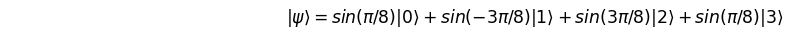

In [5]:
import matplotlib.pyplot as plt

state_string = r'|\psi\rangle ='
for idx in range(statevector.shape[0]):
    angle = np.arcsin(statevector[idx].real * np.sqrt(2.))
    norm_angle = np.round(angle / np.pi * 8.).astype(int)
    state_string += r' sin({} \pi / 8)|{}\rangle'.format('' if norm_angle == 1 else norm_angle, idx)
    if idx != statevector.shape[0] - 1:
        state_string += '+'

plt.figure(figsize=[10., 0.2])
plt.axis('off')
t = plt.text(0.5, 0.5, '${}$'.format(state_string), fontsize='xx-large')

## その他のゲート

前半でよく使われる1量子ビットゲートと2量子ビット制御ゲートを紹介しましたが、他にも知っておくと便利なゲートがいくつかあります。

### 1、2量子ビット

```{list-table}
:header-rows: 1
* - ゲート名
  - 対象量子ビット数
  - 説明
  - Qiskitコード
* - $U_1$, $P$
  - 1
  - パラメータ$\phi$を取り、$\ket{1}$に位相$e^{i\phi}$をかける。$P(\phi)$は$R_{z}(\phi)$と等価なので、1量子ビットゲートとして利用する分にはどちらでも同じ結果が得られる。
  - `circuit.p(phi, i)`
* - $U_3$
  - 1
  - パラメータ$\theta, \phi, \lambda$を取り、単一量子ビットの任意の状態を実現する。
    ```{math}
    U_3(\theta, \phi, \lambda)\ket{0} = \cos\left(\frac{\theta}{2}\right) \ket{0} + e^{i\phi}\sin\left(\frac{\theta}{2}\right) \ket{1} \\
    U_3(\theta, \phi, \lambda)\ket{1} = -e^{i\lambda}\sin\left(\frac{\theta}{2}\right) \ket{0} + e^{i(\phi+\lambda)}\cos\left(\frac{\theta}{2}\right) \ket{1}
    ```
  - `circuit.u3(theta, phi, lambda, i)`
* - $C^i_j[U_1]$, $C^i_j[P]$
  - 2
  - パラメータ$\phi$を取り、ビット$i, j$が1であるような計算基底の位相を$\phi$前進させる。
    ```{math}
    C^i_j[U_1(\phi)] \ket{00} = \ket{00} \\
    C^i_j[U_1(\phi)] \ket{01} = \ket{01} \\
    C^i_j[U_1(\phi)] \ket{10} = \ket{10} \\
    C^i_j[U_1(\phi)] \ket{11} = e^{i\phi} \ket{11}
    ```
  - `circuit.cp(phi, i, j)`
* - SWAP
  - 2
  - 二つの量子ビットの量子状態を交換する。CNOT三回で実装できる。
    ```{math}
    \begin{align}
    & C^0_1[X]C^1_0[X]C^0_1[X] (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11}) \\
    = & C^0_1[X]C^1_0[X] (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{11} + \delta \ket{10}) \\
    = & C^0_1[X] (\alpha \ket{00} + \beta \ket{11} + \gamma \ket{01} + \delta \ket{10}) \\
    = & \alpha \ket{00} + \beta \ket{10} + \gamma \ket{01} + \delta \ket{11}
    \end{align}
    ```
  - `circuit.swap(i, j)`
```

### 3量子ビット以上

量子レジスタに対する全ての操作が1量子ビットゲートと2量子ビット制御ゲート（実際にはCNOTのみ）の組み合わせで表現できることはすでに触れましたが、実際に量子回路を書くときには3つ以上の量子ビットにかかるゲートを使用したほうがアルゴリズムをコンパクトに表現できます。そのようなゲートを含む回路を実機で実行するときには、「トランスパイル」（transpilation）という過程を経て最終的には全て1量子ビットゲートとCNOTに自動的に分解されます。

3量子ビット以上にかかるゲートも基本は制御ゲートで、よく使われるのは制御ビットが複数あるような多重制御（multi-controlled）ゲート$C^{ij\dots}_{k}[U]$です。そのうち制御ビットが2つで標的ビット1つに$X$をかける$C^{ij}_{k}[X]$は特別多用され、Toffoliゲートとも呼ばれます。

多重制御ゲートでない3量子ビットゲートの例として、controlled SWAPというものも存在します。制御ビット1つで他の2つの量子ビットの間の量子状態交換を制御します。当然制御ビットを増やしたmulti-controlled SWAPというものも考えられます。

Qiskitで多重制御ゲートに対応するコードは一般に`circuit.mc?(parameters, [controls], target)`という形を取ります。例えばToffoliゲートは

```{code-block} python
circuit.mcx([i, j], k)
```

で、$C^{ij}_{k}[R_y]$は

```{code-block} python
circuit.mcry(theta, [i, j], k)
```

となります。

## 量子状態生成

それでは、これまでに登場したゲートを使って量子状態生成のエクササイズをしましょう。

まずは回路の量子状態を表示する`show_state`という関数を定義します。

In [6]:
def show_state(circuit, amp_norm=None, phase_norm=(np.pi, '\pi')):
    """Print the quantum state of the circuit in latex markdown.
    
    Args:
        circuit (QuantumCircuit): The circuit.
        amp_norm (None or tuple): If not None, specify the normalization of the amplitudes by
            (numeric devisor, unit in latex)
        phase_norm (None or tuple): If not None, specify the normalization of the phases by
            (numeric devisor, unit in latex)
    """

    # Run the circuit in statevector_simulator and obtain the final state statevector
    simulator = Aer.get_backend('statevector_simulator')
    statevector = execute(circuit, simulator).result().data()['statevector']

    # Absolute value and the phase of the amplitudes
    absamp = np.abs(statevector)
    logamp = np.zeros_like(statevector)
    np.log(statevector, out=logamp, where=(absamp > 0.))
    phase = logamp.imag
    
    # Set the numerical tolerance for various comparisons
    tolerance = 1.e-3
        
    # Final latex string
    state = ''
    
    if amp_norm is not None:
        state += r'{} \left('.format(amp_norm[1])
    
    # Sign of each term (initialized to 0 so the first term doesn't get a + in front)
    sign = 0
    
    for idx in range(statevector.shape[0]):
        a = absamp[idx]
        p = phase[idx]
        
        # Skip terms with absolute amplitude less than tolerance
        if a < tolerance:
            continue

        # Latex string for this term
        basis_term = ''

        # Write the amplitude
        if amp_norm is None:
            # No amplitude normalization -> just write as a raw float
            basis_term += '{:.2f}'.format(a)
        else:
            # With amplitude normalization
            a /= amp_norm[0]
            
            if abs(a - np.round(a)) < tolerance:
                # Amplitude is integer * norm
                if np.round(a) != 1.:
                    basis_term += '{:d}'.format(np.round(a).astype(int))
            else:
                # Otherwise float * norm
                basis_term += '{:.2f}'.format(a)

        # Write the phase
        if abs(p) > tolerance:
            while p < 0.:
                p += 2. * np.pi
            
            # First check if the phase is a multiple of pi or pi/2
            pbypi = p / np.pi
            if abs(pbypi - np.round(pbypi)) < tolerance:
                # Multiple of pi
                pbypi = abs(np.round(pbypi).astype(int))
                if pbypi % 2 == 1:
                    sign = -1
            elif abs(2. * pbypi - np.round(2. * pbypi)) < tolerance:
                # Multiple of pi/2
                twopbypi = np.round(2. * pbypi).astype(int)
                if twopbypi % 2 == 1:
                    basis_term += 'i'
                if twopbypi % 4 == 3:
                    sign = -1
            else:
                basis_term += 'e^{'
                if phase_norm is None:
                    # No phase normalization -> write as exp(raw float * i)
                    basis_term += '{:.2f}'.format(p)
                else:
                    # With phase normalization -> write as exp(divident * norm * i)
                    p /= phase_norm[0]
                    
                    if abs(p - np.round(p)) < tolerance:
                        if np.round(p) != 1.:
                            basis_term += r'{:d} \cdot '.format(np.round(p).astype(int))
                    else:
                        basis_term += r'{:.2f} \cdot '.format(p)

                    basis_term += phase_norm[1]

                basis_term += r' i}'
                
        basis_term += r' |{}\rangle'.format(idx)

        if sign == 1:
            state += ' + '
        elif sign == -1:
            state += ' - '
            
        state += basis_term
        
        sign = 1
        
    if amp_norm is not None:
        state += r'\right)'
    
    plt.figure(figsize=[10., 0.2])
    plt.axis('off')
    plt.text(0.5, 0.5, '${}$'.format(state), fontsize='xx-large')

### 問題1: 1量子ビット、相対位相付き

**問題**

1量子ビットに対して状態

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{1}\right)
$$

を作りなさい。

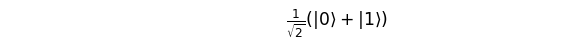

In [7]:
circuit = QuantumCircuit(1)
##################
### EDIT BELOW ###
##################
circuit.h(0)
# circuit.?
##################
### EDIT ABOVE ###
##################

show_state(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))

**解答**

正解は無限に存在しますが、上の回路ですでにアダマールゲートがかかっているので、最も手っ取り早いのは

```{code-block} python
circuit.h(0)
circuit.p(np.pi / 2., 0)
```

でしょう。自分で入力して確認してみてください。

また、上で触れたように、単一量子ビットの場合、$U_3$ゲートを使えば任意の状態を一つのゲート操作で生成できます。$U_3$を使った解答は

```{code-block} python
circuit.u3(np.pi / 2., np.pi / 2., 0., 0)
```

です。

### 問題2: ベル状態、相対位相付き

**問題**

2量子ビットに対して状態

$$
\frac{1}{\sqrt{2}}\left(\ket{0} + i\ket{3}\right)
$$

を作りなさい。

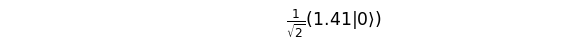

In [8]:
circuit = QuantumCircuit(2)

##################
### EDIT BELOW ###
##################
# circuit.?
circuit.cx(0, 1)
##################
### EDIT ABOVE ###
##################

show_state(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))

**解答**

問題1の結果を利用すると簡単です。初期状態は両ビットとも$\ket{0}$なので、2ビットレジスタに対して問題1の操作をすると状態$1/\sqrt{2}(\ket{0} + i\ket{1})\ket{0}$ができます。ここでビット0から1にCNOTをかけると、$\ket{1}\ket{0} \rightarrow \ket{1}\ket{1}$となるので、望む状態が実現します。

```{code-block} python
circuit.h(0)
circuit.p(np.pi / 2., 0)
circuit.cx(0, 1)
```

### 問題3: GHZ状態

**問題**

3量子ビットに対して状態

$$
\frac{1}{\sqrt{2}} (\ket{0} + \ket{7})
$$

を作りなさい。

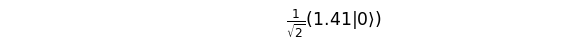

In [9]:
circuit = QuantumCircuit(3)

##################
### EDIT BELOW ###
##################
# circuit.?
circuit.mcx([0, 1], 2)
##################
### EDIT ABOVE ###
##################

show_state(circuit, amp_norm=(np.sqrt(0.5), r'\frac{1}{\sqrt{2}}'))

**解答**

Bell状態の生成と発想は同じですが、多重制御ゲート$C^{01}_2[X]$を利用します。

```{code-block} python
circuit.h(0)
circuit.cx(0, 1)
circuit.mcx([0, 1], 2)
```

### 問題4: Equal superposition

**問題**

一般の$n$量子ビットに対して状態

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

を作る回路を考え、$n=4$のケースを実装しなさい。

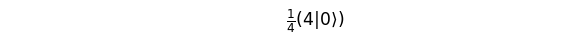

In [10]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = np.sqrt(2 ** num_qubits)
show_state(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{' + str(int(sqrt_2_to_n)) + '}'))

**解答**

Equal superpositionと呼ばれるこの状態は、量子計算でおそらく一番多様される状態です。一見複雑に思えますが、$n$桁の二進数で$0$から$2^n-1$までの数を表現すると、全ての0/1の組み合わせが登場するということを考えると、

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \otimes \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \otimes \cdots \otimes \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})
$$

と、$n$個の$1/\sqrt{2}(\ket{0} + \ket{1})$の積と等しいことがわかります。つまり各ビットに対してアダマールゲートをかけた状態にほかならず、

```{code-block} python
for i in range(4):
    circuit.h(i)
```

が正解です。

### 問題5: 特定の基底の符号を反転させる

**問題**

問題4の4ビットequal superposition状態において、基底$\ket{5}$の符号を反転させなさい。

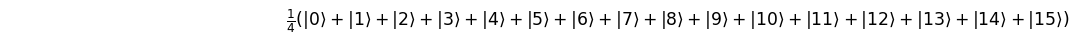

In [11]:
num_qubits = 4

circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
for i in range(num_qubits):
    circuit.h(i)
    
# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = np.sqrt(2 ** num_qubits)
show_state(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{' + str(int(sqrt_2_to_n)) + '}'))

**解答**

$\ket{5}=\ket{0101}$の符号を反転させるには、4つの量子ビットが0, 1, 0, 1という値を取っている状態のみに作用するゲートを使います。必然的に多重制御ゲートが用いられますが、残念ながら制御ゲートはビットの値が1であるときにしか働きません。そこで、まず$\ket{0101}$を$\ket{1111}$に変換し、その上で$C^{012}_{3}[Z]$を使います[^mcz]。符号を反転させたら、最初の操作の逆操作をして$\ket{1111}$を$\ket{0101}$に変換します。

```{code-block} python
for i in range(4):
    circuit.h(i)

circuit.x(1)
circuit.x(3)
circuit.mcz([0, 1, 2], 3)
circuit.x(1) # Xの逆操作はX
circuit.x(3)
```

ビット1と3にかかっている$X$ゲートは当然他の基底にも影響するので、例えば$\ket{0011}$は$\ket{0110}$となります。しかし、1と3に$X$をかけて$\ket{1111}$になるのは$\ket{0101}$だけなので、逆操作でちゃんと「後片付け」さえすれば、この一連の操作で$\ket{5}$だけをいじることができます。

[^mcz]: （多重）制御$Z$ゲートはどのビットを制御と呼んでも標的と呼んでも同じ作用をするので、$C^{123}_0[Z]$でもなんでも構いません。

### 問題6: Equal superpositionに位相を付ける

**問題**

一般の$n$量子ビットに対して状態

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k} \quad (j \in \mathbb{N})
$$

を作る回路を考え、$n=6, j=3$のケースを実装しなさい。

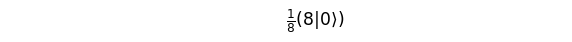

In [12]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

j = 3

##################
### EDIT BELOW ###
##################
#for i in range(num_qubits):
#    circuit.h(i)
    
# circuit.?
##################
### EDIT ABOVE ###
##################

sqrt_2_to_n = np.sqrt(2 ** num_qubits)
show_state(circuit, amp_norm=(1. / sqrt_2_to_n, r'\frac{1}{' + str(int(sqrt_2_to_n)) + '}'), phase_norm=(2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{' + str(2 ** num_qubits) + '}'))

**解答**

この回路は{doc}`後の実習 <qft>`で登場する量子フーリエ変換と深く関係しますが、量子フーリエ変換では任意の状態$\ket{j}$を上の状態に変換するのに対し、この問題では$j$は外から与えられているパラメータです。そのため回路もだいぶ簡単になり、実は制御ゲートなしで実装できます。

問題4と同じように、この状態も個々の量子ビットにおける$\ket{0}$と$\ket{1}$の重ね合わせの積として表現できます。そのためには$k$の二進数表現$k = \sum_{m=0}^{n-1} 2^m k_m \, (k_m=0,1)$を用いて、$\ket{k}$の位相を

$$
\exp\left(2\pi i \frac{jk}{2^n}\right) = \exp \left(2\pi i \frac{j}{2^n} \sum_{m=0}^{n-1} 2^m k_m\right) = \prod_{m=0}^{n-1} \exp \left(2\pi i \frac{j}{2^{n-m}} k_m\right)
$$

と分解します。一方

$$
\ket{k} = \ket{k_{n-1}} \otimes \ket{k_{n-2}} \otimes \cdots \ket{k_0}
$$

なので、

$$
e^{2\pi i jk/2^n} \ket{k} = e^{2\pi i jk_{n-1}/2} \ket{k_{n-1}} \otimes \cdots \otimes e^{2\pi i jk_{1}/2^{n-1}} \ket{k_1} \otimes e^{2\pi i jk_{0}/2^n} \ket{k_{0}}.
$$

最後に、$k_m = 0$ならば$e^{2\pi i jk_{m}/2^n} = 1$であることから、

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k} = \frac{1}{\sqrt{2}} \left(\ket{0} + e^{2\pi i j/2} \ket{1}\right) \otimes \cdots \otimes \frac{1}{\sqrt{2}} \left(\ket{0} + e^{2\pi i j/2^n} \ket{1}\right)
$$

がわかります。

```{code-block} python
j = 3
for m in range(num_qubits):
    circuit.h(m)
    circuit.p(2. * np.pi * j / (2 ** (num_qubits - m)), m)
```

が正解となります。

## [課題]ダブルスリット実験のシミュレーション